In [13]:
from predict import *
import librosa

f_name = 'data/LibriTTS/dev-other/1650/173551/1650_173551_000011_000001'
audio_data, _ = librosa.load(f'{f_name}.wav')
with open(f'{f_name}.normalized.txt', 'r') as f:
    text = f.read()
print(text)

There was no one in the passage.


In [8]:
import matplotlib.pylab as plt
import numpy as np

def plot_data(data):
    db_data = librosa.power_to_db(data, ref=np.max)
    librosa.display.specshow(db_data, sr=22050, x_axis='time', y_axis='mel')


In [14]:
output = predict(text, f'{f_name}.wav')
output.shape

torch.Size([1, 5000, 80])

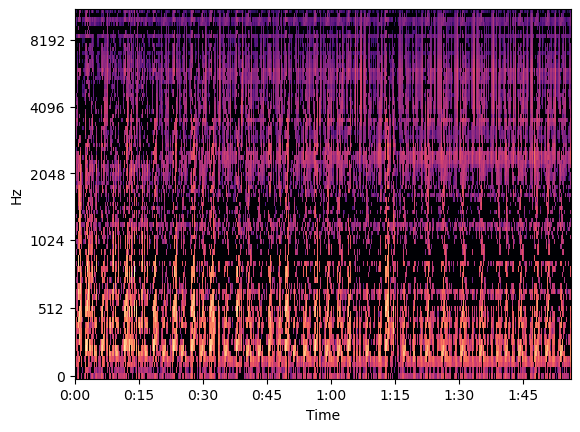

In [15]:
plot_data(output.squeeze(0).T)

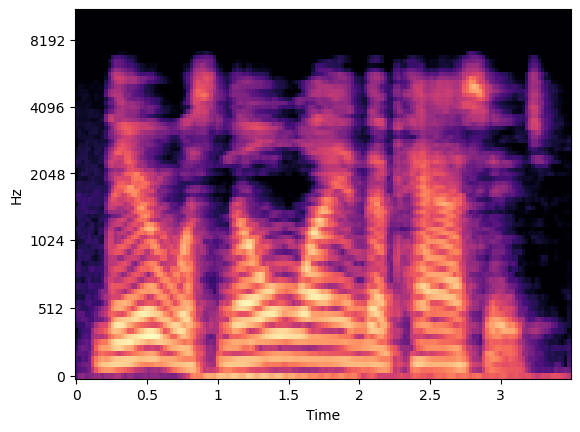

In [16]:
audio_data, _ = librosa.load(f'{f_name}.wav')
input_mels = melspec(audio_data)
plot_data(input_mels.T)

In [17]:
mels = output.squeeze(0).transpose(0, 1).numpy()
audio_output = vocoder(mels)
import soundfile as sf
sf.write('test.wav', audio_output, 22050)

In [42]:
output[:, 10].numpy(), input_mels[:, 10]

(array([[ 0.08042813,  0.02848172,  0.00595652,  0.15548462,  0.43565276,
          0.6062386 ,  0.5731425 ,  0.26395306,  0.05942557, -0.06884467,
          0.0037612 ,  0.20623282,  0.41546178,  0.2447656 , -0.00247961,
         -0.23688522, -0.02547681,  0.00442691,  0.13855106, -0.03402193,
         -0.10251234,  0.19126841, -0.04423274,  0.00078192,  0.10583839,
         -0.04619159, -0.19806397, -0.09722917,  0.00912519,  0.02804174,
          0.00248922,  0.02823021,  0.01165273, -0.00913575, -0.02405963,
         -0.03582822, -0.01951244, -0.00163386, -0.00946127,  0.01852951,
          0.04434649, -0.03468868, -0.00535109, -0.01016088,  0.00865674,
         -0.00483856,  0.00352278, -0.01329657,  0.00388988,  0.01908394,
         -0.00646875,  0.0118333 , -0.01154497, -0.00701012,  0.00224328,
         -0.00344808, -0.00631821,  0.00337178, -0.00552891, -0.00910336,
         -0.00195628, -0.00153395,  0.01012962, -0.00789928,  0.02560073,
         -0.00744015, -0.01692683, -0.